<a href="https://colab.research.google.com/gist/ziadahmed122/b48903b3617669891e89afddb573ca43/untitled52.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#loading the needed libraries 
import pandas as pd
import numpy as np
import scipy.stats as sts
import pystan
from IPython.display import display
import matplotlib.pyplot as plt

In [4]:
#Laoding the dataset and viewing the frist 5 values 
values = pd.read_csv(
    "https://raw.githubusercontent.com/MoGaber/aaa/master/weekly_in_situ_co2_mlo2.csv",skiprows=1, names=["Date", "Concentration_in_ppm"])
values["Date"] = pd.to_datetime(values["Date"])#turning the date format to datetime

print("There are",len(values),"points in this Dataset")
display(values.head())

There are 3139 points in this Dataset


,Date,Concentration_in_ppm
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


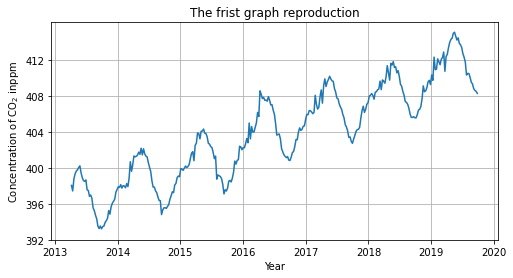

In [5]:
Figure1 = plt.figure(figsize=(8,4))
plt.plot(values.loc[2800:, ["Date"]], values.loc[2800:, ["Concentration_in_ppm"]])
plt.grid()
plt.xlabel("Year")
plt.ylabel(r'Concentration of CO$_2$ inppm')
plt.title('The frist graph reproduction')
plt.yticks(np.linspace(392, 412, 6))
plt.show()
Figure1.savefig("Figure1.png")

In [6]:
#calculating the number of years since the begining of the data collection 
values["Years"] = ((pd.to_datetime(values.Date) - pd.to_datetime(values.Date[0])).dt.days) / 365.25
# Relative time past for the exponistial function
values["Time"] = values["Years"] / max(values["Years"])
display(values.tail())

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,Date,Concentration_in_ppm,Years,Time
3134,2019-08-31,409.32,61.423682,0.998754
3135,2019-09-07,408.80,61.442847,0.999065
3136,2019-09-14,408.61,61.462012,0.999377
3137,2019-09-21,408.50,61.481177,0.999688
3138,2019-09-28,408.28,61.500342,1.000000


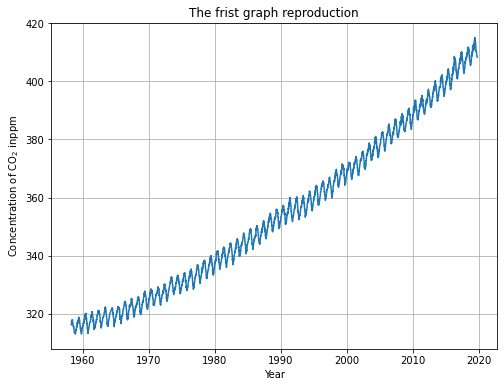

In [7]:
Figure2 = plt.figure(figsize=(8,6))
plt.plot(values.Date, values.Concentration_in_ppm)
plt.grid()
plt.xlabel("Year")
plt.ylabel(r'Concentration of CO$_2$ inppm')
plt.title('The frist graph reproduction')
plt.show()
Figure2.savefig("Figure2.png")

In [0]:
#assisng the Long-term trend of the Data 
Model_trend_linear = """
data {
    int<lower=0> num_values;             // The number of data points in the dataset 
    real<lower=0> passed_time[num_values];      // Time passed since start of data collection
    real<lower=0> Concentration_in_ppms[num_values];      // measured Concentration of the CO2
    }

parameters {
    real<lower=0> Alpha ;                 
    real<lower=0> Beta;
    real<lower=0> distorsion ;
    }

model {
 
    // Prior distrbution for the Long-term trend of the Data 
    Alpha  ~ normal(300, 20);
    Beta ~ normal(1, 2);
    distorsion  ~ normal(10, 2);
    
    for (i in 1:num_values) {
        Concentration_in_ppms[i] ~ normal(Alpha + Beta*passed_time[i], distorsion ); 
    }
}

"""

Model_trend_quad = """
data {
    int<lower=0> num_values;             // The number of data points in the dataset 
    real<lower=0> passed_time[num_values];      // Time passed since start of data collection
    real<lower=0> Concentration_in_ppms[num_values];      // measured Concentration of the CO2
    }

parameters {
    real<lower=0> Alpha ;                
    real Beta;
    real omega;
    real<lower=0> distorsion ;
    }

model {
 
    // Functions for prior distrbutions
    Alpha  ~ normal(300, 20);
    Beta ~ normal(0, 10);
    omega ~ normal(0, 2);
    distorsion  ~ normal(10, 2);
    
    for (i in 1:num_values) {
        Concentration_in_ppms[i] ~ normal(Alpha + Beta*passed_time[i] + omega*(passed_time[i]^2), distorsion ); 
    }
}

"""

Model_trend_expo = """
data {
    int<lower=0> num_values;             // The number of data points in the dataset 
    real<lower=0> passed_time[num_values];       // Time passed since start of data collection
    real<lower=0> Concentration_in_ppms[num_values];      // measured Concentration of the CO2
    }

parameters {
    real<lower=0> Alpha ;                
    real<lower=0> Beta;
    real<lower=0> distorsion ;
    }

model {
 
    // Functions for prior distrbutions
    Alpha  ~ normal(300, 20);
    Beta ~ normal(1, 1);
    distorsion  ~ normal(5, 2);
    for (i in 1:num_values) {
        Concentration_in_ppms[i] ~ normal(Alpha*exp( Beta *passed_time[i]), distorsion ); 
    }
    }

"""

In [35]:
Model_linear_sampling = pystan.StanModel(model_code= Model_trend_linear)
Model_quadratic_sampling = pystan.StanModel(model_code= Model_trend_quad)
Model_expo_sampling = pystan.StanModel(model_code= Model_trend_expo)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d30c576d05a5b97284a3b630712d2688 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5975363ad15c450cd9f500e8db4849d4 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_968f6c1d3eac9d417dff41c87766469e NOW.


In [0]:
stan_years_values = {
    "num_values" : len(values),
    "passed_time" : values.Years.values,
    "Concentration_in_ppms" : values.Concentration_in_ppm.values
}

stan_values_passed_time = {
    "num_values" : len(values),
    "passed_time" : values.Time.values,
    "Concentration_in_ppms" : values.Concentration_in_ppm.values
}

In [37]:
Model_linear_results = Model_linear_sampling.sampling(data=stan_years_values)
print(Model_linear_results)

Inference for Stan model: anon_model_d30c576d05a5b97284a3b630712d2688.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Alpha      306.06  3.6e-3   0.16 305.75 305.96 306.06 306.17 306.38   1972    1.0
Beta         1.57  1.1e-4 4.4e-3   1.57   1.57   1.57   1.58   1.58   1576    1.0
distorsion   4.27  1.5e-3   0.05   4.17   4.24   4.27   4.31   4.38   1270    1.0
lp__        -6121    0.04   1.25  -6124  -6122  -6121  -6120  -6120   1210    1.0

Samples were drawn using NUTS at Tue May  5 23:40:33 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [38]:
Model_quad_results = Model_quadratic_sampling.sampling(data=stan_years_values, iter=2000)
print(Model_quad_results)

Inference for Stan model: anon_model_5975363ad15c450cd9f500e8db4849d4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Alpha      314.58  4.0e-3   0.12 314.33  314.5 314.58 314.66 314.81    941    1.0
Beta         0.77  3.3e-4 9.1e-3   0.75   0.76   0.77   0.77   0.79    753    1.0
omega        0.01  5.1e-6 1.4e-4   0.01   0.01   0.01   0.01   0.01    780    1.0
distorsion   2.25  7.6e-4   0.03   2.19   2.23   2.25   2.27   2.31   1467    1.0
lp__        -4116    0.04   1.41  -4119  -4116  -4115  -4115  -4114   1006    1.0

Samples were drawn using NUTS at Tue May  5 23:43:56 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [39]:
Model_expo_results = Model_expo_sampling.sampling(data=stan_values_passed_time, iter=2000)
print(Model_expo_results)

Inference for Stan model: anon_model_968f6c1d3eac9d417dff41c87766469e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Alpha      307.98  2.6e-3   0.11 307.76  307.9 307.98 308.06  308.2   1856    1.0
Beta         0.27  1.4e-5 6.0e-4   0.27   0.27   0.27   0.28   0.28   1698    1.0
distorsion   3.47  1.5e-3   0.04   3.39   3.44   3.47    3.5   3.56    828    1.0
lp__        -5472    0.03   1.14  -5475  -5472  -5471  -5471  -5470   1546    1.0

Samples were drawn using NUTS at Tue May  5 23:45:00 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


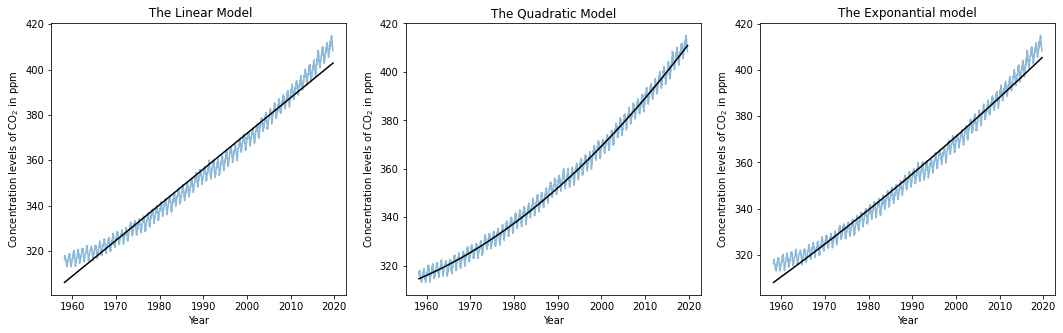

In [40]:
#getting the results from the stan sampling 
approx_sampling_linear = Model_linear_results.extract()
approx_sampling_quad = Model_quad_results.extract()
approx_sampling_expo = Model_expo_results.extract()
#getting the approximation values
approx_values_linear = approx_sampling_linear['Alpha'].mean() + approx_sampling_linear['Beta'].mean()*values.Years.values
approx_values_quad = approx_sampling_quad['Alpha'].mean() +\
                     approx_sampling_quad['Beta'].mean()*values.Years.values +\
                     approx_sampling_quad['omega'].mean()*values.Years.values**2
approx_values_expo = approx_sampling_expo['Alpha'].mean()*np.exp(approx_sampling_expo['Beta'].mean()*values.Time.values)
#plotting
Figure3 = plt.figure(figsize=(18,5))
plt.subplot(1, 3, 1)
plt.plot(values.Date, values.Concentration_in_ppm, alpha=0.5)
plt.plot(values.Date, approx_values_linear, color="black")
plt.title(" The Linear Model")
plt.xlabel("Year")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
plt.subplot(1, 3, 2)
plt.plot(values.Date, values.Concentration_in_ppm, alpha=0.5)
plt.plot(values.Date, approx_values_quad, color="black")
plt.title("The Quadratic Model")
plt.xlabel("Year")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
plt.subplot(1, 3, 3)
plt.plot(values.Date, values.Concentration_in_ppm, alpha=0.5)
plt.plot(values.Date, approx_values_expo, color="black")
plt.title("The Exponantial model")
plt.xlabel("Year")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
plt.show()
Figure3.savefig("Figure3.png")

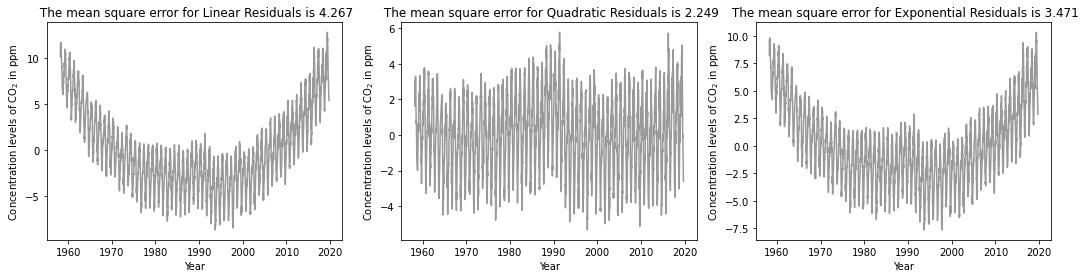

In [46]:
#testing the error in the data 
error_linear = values.Concentration_in_ppm - approx_values_linear
error_quadratic = values.Concentration_in_ppm - approx_values_quad
error_exp = values.Concentration_in_ppm - approx_values_expo

linear_mean_sqr_error = np.sqrt(np.mean(error_linear**2))
quadratic_mean_sqr_error = np.sqrt(np.mean(error_quadratic**2))
exp_mean_sqr_error = np.sqrt(np.mean(error_exp**2))
#ploting the mean square error graphs 
fig4 = plt.figure(figsize=(18,4))
plt.subplot(1, 3, 1)
plt.plot(values.Date, error_linear, alpha = 0.8, color="grey")
plt.title(" The mean square error for Linear Residuals is {:.3f}".format(linear_mean_sqr_error))
plt.xlabel("Year")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
plt.subplot(1, 3, 2)
plt.plot(values.Date, error_quadratic, alpha = 0.8, color="grey")
plt.title(" The mean square error for Quadratic Residuals is {:.3f}".format(quadratic_mean_sqr_error))
plt.xlabel("Year")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
plt.subplot(1, 3, 3)
plt.plot(values.Date, error_exp, alpha = 0.8, color="grey")
plt.title(" The mean square error for Exponential Residuals is {:.3f}".format(exp_mean_sqr_error))
plt.xlabel("Year")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
plt.show()
fig4.savefig("Figure4.png")

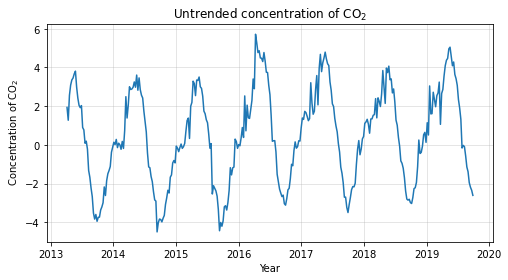

In [47]:
#plotting the seasonality in the data 
values["Concentration_untrend"] = error_quadratic
#showing the figure 
Figure5 = plt.figure(figsize=(8,4))
plt.plot(values.loc[2800:, ["Date"]], values.loc[2800:, ["Concentration_untrend"]])
plt.grid(alpha=0.4)
plt.title(r'Untrended concentration of CO$_2$')
plt.xlabel("Year")
plt.ylabel(r' Concentration of CO$_2$')
plt.show()
Figure5.savefig("Figure5.png")

In [0]:
stan_years_values = {
    "num_values" : len(values),
    "day" : values.Years.values,
    "Concentration_in_ppms" : values.Concentration_untrend.values,
    "interval" : 2*np.pi
}

In [49]:
Model_Sine_Code = """
data {
    int<lower=0> num_values;             // The number of data points in the dataset 
    real<lower=0> day[num_values];       // Time passed since start of data collection
    real Concentration_in_ppms[num_values];      // measured Concentration of the CO2
    real<lower=0> interval;
}

parameters {
    real<lower=0> Alpha ;
    unit_vector[2] state_prameter_1;
    real<lower=0> distorsion ;
}

transformed parameters {
    real inital_state = atan2(state_prameter_1[1],state_prameter_1[2]);
}

model {
 
    // Functions for prior distrbutions
    Alpha  ~ normal(4, 2);
    distorsion  ~ inv_gamma(3, 2);

    for (i in 1:num_values) {
        Concentration_in_ppms[i] ~ normal(Alpha *sin(interval*day[i] + inital_state), distorsion ); 
    }
}

"""

Model_Cos_Code = """
data {
    int<lower=0> num_values;             // The number of data points in the dataset 
    real<lower=0> day[num_values];       // Time passed since start of data collection
    real Concentration_in_ppms[num_values];      // measured Concentration of the CO2
    real<lower=0> interval;
}

parameters {
    real<lower=0> Alpha ;
    unit_vector[2] state_prameter_1;
    real<lower=0> distorsion ;
}

transformed parameters {
    real inital_state = atan2(state_prameter_1[1],state_prameter_1[2]);
}

model {
 
    // Functions for prior distrbutions
    Alpha  ~ normal(4, 2);
    distorsion  ~ inv_gamma(3, 2);

    for (i in 1:num_values) {
        Concentration_in_ppms[i] ~ normal(Alpha*cos(interval*day[i] + inital_state), distorsion ); 
    }
}

"""

double_negative_Model_Sine_Code = """
data {
    int<lower=0> num_values;             // The number of data points in the dataset 
    real<lower=0> day[num_values];       // Time passed since start of data collection
    real Concentration_in_ppms[num_values];      // measured Concentration of the CO2
    real<lower=0> interval;
}

parameters {
    real<lower=0> Alpha ;                
    real<lower=0> Beta;
    unit_vector[2] state_prameter_1;
    real<lower=0> distorsion ;
}

transformed parameters {
    real inital_state = atan2(state_prameter_1[1],state_prameter_1[2]);
}

model {
 
    // Functions for prior distrbutions
    Alpha  ~ normal(0, 4);
    Beta ~ normal(0, 4);
    distorsion  ~ inv_gamma(3, 2);

    for (i in 1:num_values) {
        Concentration_in_ppms[i] ~ normal(Alpha*sin(interval*day[i] + inital_state) + Beta*sin(interval*2*day[i] + inital_state), distorsion ); 
    }
}

"""
sine_model = pystan.StanModel(model_code=Model_Sine_Code)
cos_model = pystan.StanModel(model_code=Model_Cos_Code)
double_negative_sine_model = pystan.StanModel(model_code=double_negative_Model_Sine_Code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ca29deb14e9c9170abc52181ccb9ffa NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2bb8262389e54c8950eef31dc5222bbe NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cc45b86b61fc50b0f5d8f0413b3daf6e NOW.


In [50]:
Model_Sine_results = sine_model.sampling(data=stan_years_values, iter=1000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 12, 'adapt_delta' : 0.9999},
                              refresh = 10)
print(Model_Sine_results)

Inference for Stan model: anon_model_3ca29deb14e9c9170abc52181ccb9ffa.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Alpha                 2.86  7.8e-4   0.02   2.81   2.84   2.86   2.88   2.91   1000    1.0
state_prameter_1[1]   0.91  8.1e-5 3.5e-3   0.91   0.91   0.91   0.92   0.92   1867    1.0
state_prameter_1[2]    0.4  1.8e-4 7.9e-3   0.39    0.4    0.4   0.41   0.42   1864    1.0
distorsion            0.98  4.0e-4   0.01   0.96   0.98   0.98   0.99   1.01    930    1.0
inital_state          1.15  2.0e-4 8.7e-3   1.14   1.15   1.15   1.16   1.17   1864    1.0
lp__                 -1523    0.07   1.53  -1527  -1524  -1523  -1522  -1521    425    1.0

Samples were drawn using NUTS at Wed May  6 00:06:10 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction fac

In [51]:
Model_Cos_results = cos_model.sampling(data=stan_years_values, iter=1000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 14, 'adapt_delta' : 0.999},
                              refresh = 10)
print(Model_Cos_results)

Inference for Stan model: anon_model_2bb8262389e54c8950eef31dc5222bbe.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Alpha                 2.86  7.8e-4   0.02   2.82   2.85   2.86   2.88   2.91    969    1.0
state_prameter_1[1]   -0.4  1.9e-4 8.1e-3  -0.42  -0.41   -0.4   -0.4  -0.39   1903    1.0
state_prameter_1[2]   0.91  8.2e-5 3.6e-3   0.91   0.91   0.91   0.92   0.92   1915    1.0
distorsion            0.98  4.0e-4   0.01   0.96   0.98   0.98   0.99   1.01    969    1.0
inital_state         -0.42  2.0e-4 8.9e-3  -0.43  -0.42  -0.42  -0.41   -0.4   1905    1.0
lp__                 -1523    0.09   1.59  -1528  -1524  -1523  -1522  -1521    312   1.02

Samples were drawn using NUTS at Wed May  6 00:16:15 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction fac

In [52]:
double_negative_Model_Sine_results = double_negative_sine_model.sampling(data=stan_years_values, iter=1000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 14, 'adapt_delta' : 0.999},
                              refresh = 10)
print(double_negative_Model_Sine_results)

Inference for Stan model: anon_model_cc45b86b61fc50b0f5d8f0413b3daf6e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Alpha                 2.86  6.6e-4   0.02   2.81   2.84   2.86   2.88   2.91   1410    1.0
Beta                1.3e-3  4.1e-5 1.3e-3 2.6e-5 3.7e-4 8.7e-4 1.8e-3 4.8e-3   1042    1.0
state_prameter_1[1]   0.91  8.0e-5 3.6e-3   0.91   0.91   0.91   0.92   0.92   1986    1.0
state_prameter_1[2]    0.4  1.8e-4 8.1e-3   0.39    0.4    0.4   0.41   0.42   1978    1.0
distorsion            0.99  3.6e-4   0.01   0.96   0.98   0.99   0.99   1.01   1190    1.0
inital_state          1.15  2.0e-4 8.9e-3   1.14   1.15   1.15   1.16   1.17   1979    1.0
lp__                 -1532    0.08    1.8  -1536  -1533  -1531  -1530  -1529    456   1.01

Samples were drawn using NUTS at Wed May  6 00:43:11 2020.
For each parameter, n_eff

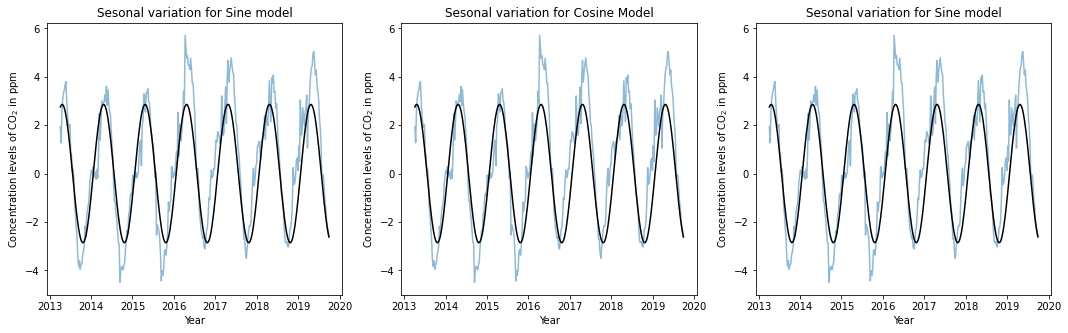

In [58]:
#sampling from the model results excluing the double negative as it was not a good fit 
Model_Sine_sampling = Model_Sine_results.extract()
Model_cos_sampling = Model_Cos_results.extract()
double_negative_sampling = double_negative_Model_Sine_results .extract()
#Approximation
Model_Sine_aprox = Model_Sine_sampling['Alpha'].mean() * np.sin(2*np.pi*values.Years.values + Model_Sine_sampling['inital_state'].mean())
Model_Cos_aprox = Model_cos_sampling['Alpha'].mean() * np.cos(2*np.pi*values.Years.values + Model_cos_sampling['inital_state'].mean())
Model_double_negative_aprox = double_negative_sampling['Alpha'].mean()*np.sin(
                                 2*np.pi*values.Years.values + double_negative_sampling['inital_state'].mean()) + \
                              double_negative_sampling['Beta'].mean()*np.sin(
                                 4*np.pi*values.Years.values + double_negative_sampling['inital_state'].mean())
#ploting the figures 
Figure6 = plt.figure(figsize=(18,5))
plt.subplot(1, 3, 1)
plt.plot(values.loc[2800:, ["Date"]], values.loc[2800:, ["Concentration_untrend"]], alpha=0.5)
plt.plot(values.loc[2800:, ["Date"]], Model_Sine_aprox[2800:], color="black")
plt.title("Sesonal variation for Sine model")
plt.xlabel("Year")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
plt.subplot(1, 3, 2)
plt.plot(values.loc[2800:, ["Date"]], values.loc[2800:, ["Concentration_untrend"]], alpha=0.5)
plt.plot(values.loc[2800:, ["Date"]], Model_Cos_aprox[2800:], color="black")
plt.title("Sesonal variation for Cosine Model")
plt.xlabel("Year")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
plt.subplot(1, 3, 3)
plt.plot(values.loc[2800:, ["Date"]], values.loc[2800:, ["Concentration_untrend"]], alpha=0.5)
plt.plot(values.loc[2800:, ["Date"]], Model_double_negative_aprox[2800:], color="black")
plt.title("Sesonal variation for double Sine model")
plt.xlabel("Year")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
Figure6.savefig("Figure6.png")


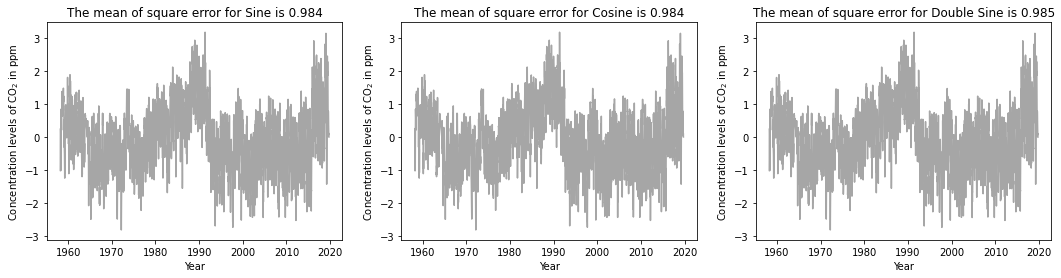

In [60]:
#getting the square error values as a testing metric
error_sine = values.Concentration_untrend - Model_Sine_aprox
error_cos = values.Concentration_untrend - Model_Cos_aprox
error_double_sine = values.Concentration_untrend - Model_double_negative_aprox

sine_mean_sqr_error = np.sqrt(np.mean(error_sine**2))
cos_mean_sqr_error = np.sqrt(np.mean(error_cos**2))
double_sine_mean_sqr_error = np.sqrt(np.mean(error_double_sine**2))

Figure7 = plt.figure(figsize=(18,4))
plt.subplot(1, 3, 1)
plt.plot(values.Date, error_sine, alpha = 0.7, color="grey")
plt.title("The mean of square error for Sine is {:.3f}".format(sine_mean_sqr_error))
plt.xlabel("Year")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
plt.subplot(1, 3, 2)
plt.plot(values.Date, error_cos, alpha = 0.7, color="grey")
plt.title("The mean of square error for Cosine is {:.3f}".format(cos_mean_sqr_error))
plt.xlabel("Year")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
plt.subplot(1, 3, 3)
plt.plot(values.Date, error_double_sine, alpha = 0.7, color="grey")
plt.title("The mean of square error for Double Sine is {:.3f}".format(double_sine_mean_sqr_error))
plt.xlabel("Year")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
plt.show()
Figure7.savefig("Figure7.png")

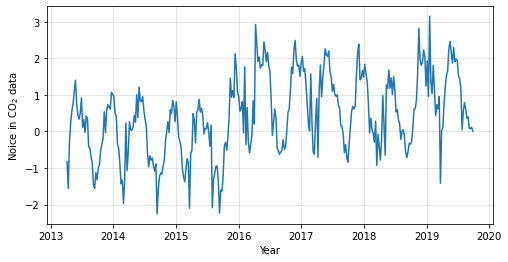

In [61]:
#recreation of the noise in the data
values["distorsion_Concentration_in_ppm"] = error_double_sine
#plotting
Figure8 = plt.figure(figsize=(8,4))
plt.plot(values.loc[2800:, ["Date"]], values.loc[2800:, ["distorsion_Concentration_in_ppm"]])
plt.grid(alpha=0.4)
plt.xlabel("Year")
plt.ylabel(r'Noice in CO$_2$ data')
plt.show()
Figure8.savefig("Figure8.png")

In [0]:
#getting the coeffecients needed for the Likelihood_function
Coef_samples_trending = np.array(list(map(list, zip(*approx_sampling_quad.values()))))[:2000, :3]
Coef_samples_seasonal_var = list(map(list, zip(*double_negative_sampling.values())))
#ignorinig the state prameter
Coef_samples_seasonal_var = np.array([sample[:2] + sample[3:5] for sample in Coef_samples_seasonal_var])

In [0]:
# defining the liklehood function 
def Likelihood_function(passed_time, coeffs_trend_values, coeffs_season_var_values):
    coeff_0, coeff_1, coeff_2 = coeffs_trend_values
    coeff_3, coeff_4, distorsion , condition = coeffs_season_var_values
    return(np.array(sts.norm.rvs(coeff_0 + coeff_1*passed_time + coeff_2*passed_time**2 + \
                                 coeff_3*np.sin(2*np.pi*passed_time + condition) + \
                                 coeff_4*np.sin(4*np.pi*passed_time + condition), distorsion )))

In [0]:
#The year we want preiction on 
date_predict = pd.date_range("2019-01-01", "2058-03-29", freq='W-FRI')
passed_times_predict = (date_predict - pd.to_datetime(values.Date[0])).days / 365.25
#intiationg the prediction
prediction_outcome = np.array([Likelihood_function(passed_times_predict, coeffs_trend_values, coeffs_season_var_values) \
                   for coeffs_trend_values, coeffs_season_var_values in zip(Coef_samples_trending, Coef_samples_seasonal_var)])

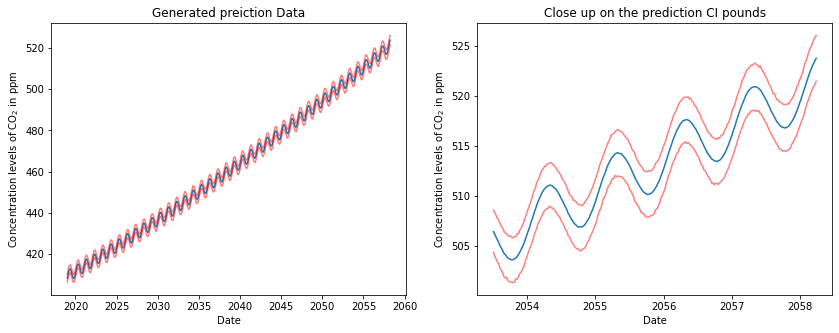

In [67]:
#generating the confedance intervals
prediction_mean = prediction_outcome.mean(axis=0)
conf_interval_lower = np.percentile(prediction_outcome, axis=0, q=2.5)
conf_interval_upper = np.percentile(prediction_outcome, axis=0, q=97.5)
#showing the figure
Figure10 = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Generated preiction Data")
plt.xlabel("Date")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
plt.plot(date_predict, prediction_mean)
plt.plot(date_predict, conf_interval_lower, color="red", alpha=0.5)
plt.plot(date_predict, conf_interval_upper, color="red", alpha=0.5)
#closeup of the graph
plt.subplot(1,2,2)
plt.title("Close up on the prediction CI pounds")
plt.xlabel("Date")
plt.ylabel(r'Concentration levels of CO$_2$ in ppm')
plt.plot(date_predict[1800:], prediction_mean[1800:])
plt.plot(date_predict[1800:], conf_interval_lower[1800:], color="red", alpha=0.5)
plt.plot(date_predict[1800:], conf_interval_upper[1800:], color="red", alpha=0.5)
plt.show()
Figure10.savefig("Figure10.png")


In [0]:
predicted_values = pd.DataFrame({"Date":date_predict, 
                          "2.5%":conf_interval_lower, 
                          "Mean":prediction_mean, 
                          "97.5":conf_interval_upper})

In [69]:
print('The model predicts that the atmospheric carbon dioxide level will be',predicted_values.iloc[-1,1],'in',predicted_values.iloc[-1,0])
print('The pounds of the 95% confidence interval is between',predicted_values.iloc[-1,2],'and',predicted_values.iloc[-1,3])

The model predicts that the atmospheric carbon dioxide level will be 521.5093250337417 in 2058-03-29 00:00:00
The pounds of the 95% confidence interval is between 523.7882728862786 and 526.0957010190976


In [71]:
print("The concentration of 450 will be reached approximetly on",date_predict[np.min(np.argwhere(conf_interval_lower > 450))])

The concentration of 450 will be reached approximetly on 2035-03-02 00:00:00


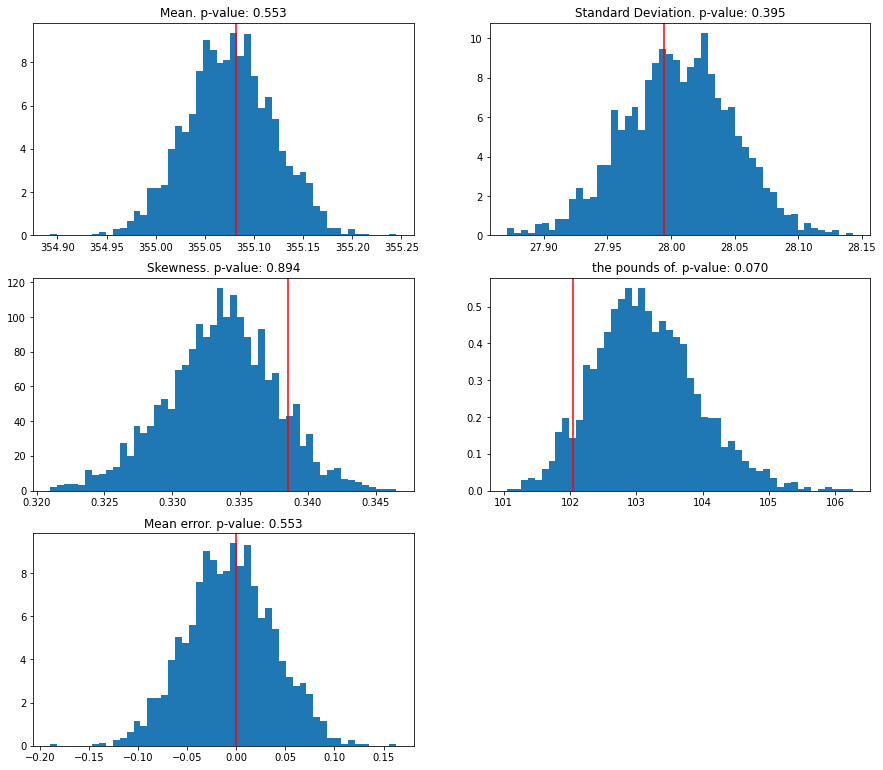

In [72]:
generated_prediction_values = np.array([Likelihood_function(values.Years.values, coeffs_trend_values, coeffs_season_var_values) \
                   for coeffs_trend_values, coeffs_season_var_values in zip(Coef_samples_trending, Coef_samples_seasonal_var)])

#Deffing a function for the histograms
def histogram_function(graph_title, data_needed, thoretical_value, number_of_subplot):
    plt.subplot(*number_of_subplot)
    plt.hist(data_needed, bins=50, density=True)
    plt.title(graph_title)
    #The expected value to compare the generated data to (practical vs thoritical)
    if thoretical_value is not None:
        plt.axvline(thoretical_value, color='red')

#the needed statistical tests to tes the model
Figure11 = plt.figure(figsize=(15,18)) 
#testing the mean 
data_needed = np.mean(generated_prediction_values, axis=1)
thoretical_value = np.mean(values.Concentration_in_ppm.values)
graph_title = 'Mean. p-value: {:.3f}'.format(np.mean(data_needed < thoretical_value))
histogram_function(graph_title, data_needed, thoretical_value, (4, 2, 1))
#testing the standered deviation
data_needed = np.std(generated_prediction_values, axis=1)
thoretical_value = np.std(values.Concentration_in_ppm.values)
graph_title = 'Standard Deviation. p-value: {:.3f}'.format(np.mean(data_needed < thoretical_value))
histogram_function(graph_title, data_needed, thoretical_value, (4, 2, 2))
#testing the skewness
data_needed = sts.skew(generated_prediction_values, axis=1)
thoretical_value = sts.skew(values.Concentration_in_ppm.values)
graph_title = 'Skewness. p-value: {:.3f}'.format(np.mean(data_needed < thoretical_value))
histogram_function(graph_title, data_needed, thoretical_value, (4, 2, 3))
#the pounds of p_value
data_needed = np.ptp(generated_prediction_values, axis=1)
thoretical_value = np.ptp(values.Concentration_in_ppm.values)
graph_title = 'the pounds of. p-value: {:.3f}'.format(np.mean(data_needed < thoretical_value))
histogram_function(graph_title, data_needed, thoretical_value, (4, 2, 4))
#mean error in the generated data 
data_needed = np.mean(generated_prediction_values - values.Concentration_in_ppm.values, axis=1)
thoretical_value = 0
graph_title = 'Mean error. p-value: {:.3f}'.format(np.mean(data_needed < thoretical_value))
histogram_function(graph_title, data_needed, thoretical_value, (4, 2, 5))
plt.show()
Figure11.savefig("Figure11.png")
